In [7]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import camb


In [8]:
#reading temp nd pol maps both full and half mission
mapt1 = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica_2048_R3.00_hm1.fits',field=0)
mapt2 = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica_2048_R3.00_hm2.fits',field=0)
mapt = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=0)
mapq = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=1)
mapu = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=2)
mapq1 = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica_2048_R3.00_hm1.fits',field=1)
mapu1 = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica_2048_R3.00_hm1.fits',field=2)
mapq2 = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica_2048_R3.00_hm2.fits',field=1)
mapu2 = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica_2048_R3.00_hm2.fits',field=2)
maskp = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=4)
maskt = hp.fitsfunc.read_map('/home/vaishali/Downloads/COM_CMB_IQU-smica.fits',field=3)
mapq = mapq*maskp
mapu = mapu*maskp
npix = mapt1.shape[0]
fp = np.count_nonzero(maskp)/npix

In [9]:
maps=np.ndarray(shape=(3,npix))
maps[0,:] = mapt*maskt
maps[1,:] = mapq*maskp
maps[2,:] = mapu*maskp

In [10]:
#getting alms,elm and blm for ful mission
alms = hp.map2alm(maps,pol=True,lmax=2000)
emap = hp.alm2map(alms[1,:],pol=False,lmax=2000,nside=1024) #check if mask needs to be mutilplied here as well
bmap = hp.alm2map(alms[2,:],pol=False,lmax=2000,nside=1024)

In [11]:
maps1=np.ndarray(shape=(3,npix))
maps2=np.ndarray(shape=(3,npix))
maps1[0,:] = mapt1*maskt
maps1[1,:] = mapq1*maskp
maps1[2,:] = mapu1*maskp
maps2[0,:] = mapt2*maskt
maps2[1,:] = mapq2*maskp
maps2[2,:] = mapu2*maskp

In [12]:
#getting alm,elm and blm for half mission
alms1 = hp.map2alm(maps1,pol=True,lmax=2000)
emap1 = hp.alm2map(alms1[1,:],pol=False,lmax=2000,nside=1024)#check if mask needs to be mutilplied here as well
bmap1 = hp.alm2map(alms1[2,:],pol=False,lmax=2000,nside=1024)

alms2 = hp.map2alm(maps2,pol=True,lmax=2000)
emap2 = hp.alm2map(alms2[1,:],pol=False,lmax=2000,nside=1024) #check if mask needs to be mutilplied here as well
bmap2 = hp.alm2map(alms2[2,:],pol=False,lmax=2000,nside=1024)


In [13]:
maskp = hp.ud_grade(maskp,nside_out=1024)

In [14]:
#Noise spectrum for e and b map from hm maps
noisemape = (emap1-emap2)*0.5*maskp
noisemapb = (bmap1-bmap2)*0.5*maskp
Nle = hp.anafast(noisemape,lmax=2000)/fp
Nlb = hp.anafast(noisemapb,lmax=2000)/fp

In [26]:
Dle = hp.anafast(emap*maskp,lmax=2000,pol=False)/fp
Dlb = hp.anafast(bmap*maskp,lmax=2000,pol=False)/fp
cle = Dle-Nle
clb = Dlb-Nlb
pw1 = hp.pixwin(nside=1024,pol=True,lmax=2000)
blq = hp.gauss_beam(0.00290888,lmax=2000,pol=True)   #fwhm = 10arcmin for Q and U map

In [27]:
el = np.ndarray(shape=(2001))
for i in range(0,2001):
    el[i] = i
ell = el*(el+1)*(10**12)/(2*np.pi)
beams = np.square(pw1[1]/blq[:,1])

In [34]:
camb.run_ini('/home/vaishali/Downloads/planck_2018_acc.ini', no_validate=False)
pars = camb.read_ini('/home/vaishali/Downloads/planck_2018_acc.ini')


at z =  0.000 sigma8 (all matter) =  0.8120
at z =  0.000 sigma8^2_vd/sigma8  =  0.4293


In [35]:
 #We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = '/home/vaishali/Downloads/planck_2018_acc'

#pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
# pars.set_for_lmax(20000)
# pars.set_accuracy(2)
results = camb.get_results(pars)

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=2000).T
cls_len = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3]}

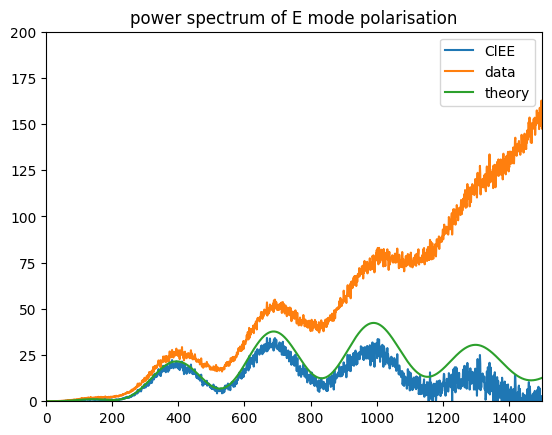

In [39]:
plt.plot(el,cle*ell,label='ClEE')
plt.plot(el,Dle*ell,label='data')
plt.plot(el,ell*camb_cls_len[1,:]/10**12,label='theory')
plt.title('power spectrum of E mode polarisation')
plt.xlim([0,1500])
plt.ylim([0,200])
plt.legend()

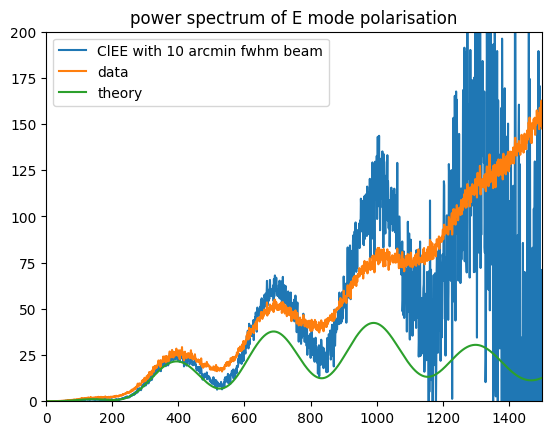

In [40]:
plt.plot(el,cle*ell*beams,label='ClEE with 10 arcmin fwhm beam')
plt.plot(el,Dle*ell,label='data')
plt.plot(el,ell*camb_cls_len[1,:]/10**12,label='theory')
plt.title('power spectrum of E mode polarisation')
plt.xlim([0,1500])
plt.ylim([0,200])
plt.legend()